## Backward Propagation 

Backward propagation is adjusting the weights and biases of neurons for each layer to decrease the error and increase the accuracy of the predictions made by the neural network with respects to the correct labels.

Back propagation uses gradient descent to minimize to the optimal weights and biases needed to minimize the error. Performing gradient descent in a neural network requires the partial derivates of all the inputs ( the impact of each neurons) and activation functions to form a gradient vector.

The neural network created in this project uses 5 functions: the multiplication of input values and weight; sum of the weighted inputs with the biases , the ReLU activation, the softmax function and the cost function. To get the gradient of the overall function, the partial derivative of each function will need to be calculated to form the gradient matrix of the neural network. This will be done by the chain rule.

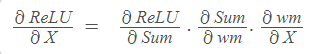

To implement the backward propagation of the current neural network framework from this project, the LayerDense class and activation function classes will need to changed. A backward method will be implemented to the objects. 

In [28]:
import numpy as np

# Layer class
class LayerDense:
    # Initialise object
    def __init__(self, inputs, neurons):
        self.weights = 0.01 * np.random.randn(inputs, neurons)
        self.biases = np.zeros((1, neurons))
        
# Forward pass. Renamed from calculate as this is the forward propagation step
    def forward(self, inputs):
        # We will need the inputs to calculate the partial derivative with respects to weights during backcprogation.
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
    
 # Backward step. The gradient of the subsequent layer with respects to inputs is used as the paramenter
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)
        
# RelU activation class
class ActivationRelU:
    # Forward step
    def forward(self, inputs):
# We need the inputs for the backward step to calculate the Relu activation function gradient
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        
    # Backward step
    def backward(self, dvalues):
        # Make a copy
        self.dinputs = dvalues.copy()
        # If the input values were negative, the value or the gradient is zero.
        self.dinputs[self.inputs <= 0] = 0

To obtain the derivative of the cost function, the derivative of the cross entropy equation will need to be applied and then the Cost class will need to be changed accordingly.
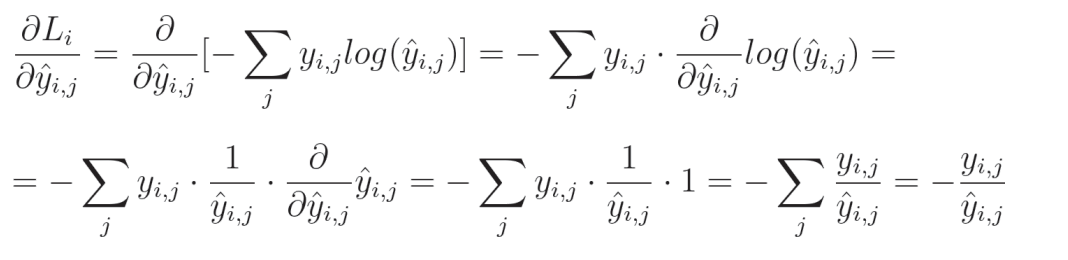

In [29]:
# Class to calculate error of an output
class Cost:
# Takes in the output layer values and the correct labels for the samples
    def calculate(self, output, y):
        # Calculate the losses for the corresponding sample in the set
        costs = self.forward(output, y)
        # Calculate mean loss in the sample
        mean_cost = np.mean(costs)
        # Return loss
        return mean_cost

# Catergorical cross entropy class that will inherit the base Cost class
class CategoricalCrossEntropy(Cost):
# Calculate the error using the predicted values from the output and 
# its corrresponding labels
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
         # Clip the predicted values to prevent error caused by inf
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # If the y_true are scalar values else use one-hot encoded labels
        if len(y_true.shape) == 1:
        # Retrieve the highest probability from each sample output from y_pred
            confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            confidences = np.sum(y_pred_clipped * y_true, axis=1)
        
        # Calculate negative log of the confidences and return the value
        negative_log_confidences = -np.log(confidences)
        return negative_log_confidences
    
    # Backward step. Takes in the softmax output as dvalues. 
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in the samples
        labels = len(dvalues[0])
        
        # If labels are scalar values, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalise gradient
        self.dinputs = self.dinputs / samples

The outer layer uses the softmax activation instead of the ReLu. The softmax derivative will need to be calculated in back propagation.

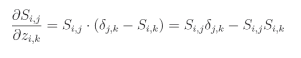

In [30]:
# Softmax activation class
class ActivationSoftmax:
    def forward(self, inputs):
        self.inputs = inputs
        # Exponentiate input values. The inputs will be subrstracted by the max value of inputs to prevent overflow.
        exp_values = np.exp(inputs - np.max(inputs, axis = 1, keepdims= True))
        # Normalise the values
        probabilities = exp_values / np.sum(exp_values, axis = 1, keepdims = True)
        self.output = probabilities
    
    # Backward step. Takes in the gradient/derivitive of the subsequent layer
    def backward(self, dvalues):
        # Create an empty array
        self.dinputs = np.empty_like(dvalues)
        
        # Enumerate outputs and gradient
        for index, (single_output, single_dvalues) in \
        enumerate(zip(self.output, dvalues)):
            
            # Reshape sample softmax output into a column vector
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the sample output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            
        # Calculate gradient (Chain Rule) and append dinputs.
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

The partial derivitive of the cost function with respect to the softmax inputs 
will also need to be calculated. The full derivation of the derivitive is shown below.

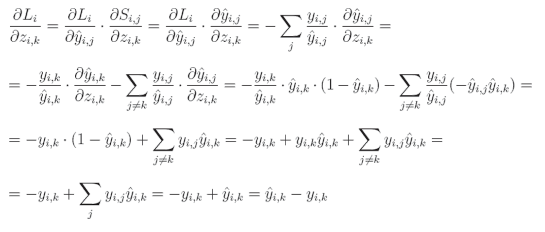

In [31]:
# Combine softmax and cost function for faster backward propagation step
class ActivationSoftmaxCost():
    # Creates activation and cost function objects
    def __init__(self):
        self.activation = ActivationSoftmax()
        self.cost = CategoricalCrossEntropy()
        
    # Forward step
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return error
        return self.cost.calculate(self.output, y_true)
    
    # Backward step. Takes in the softmax output. (Not a derivitve)
    def backward(self, dvalues, y_true):
        # Number of samples 
        samples = len(dvalues)
        
        # Ensure labels are scalar values
        if len(y_true.shape) == 2:
        # Return a vector of index where the one_hot_coded vector is positive
            y_true = np.argmax(y_true, axis = 1)
            
        # Copy the derivative values from subsequent layer function
        self.dinputs = dvalues.copy()
        # Calculate the gradient . Chain rule
        self.dinputs[range(samples), y_true] -= 1
        # Normalise the gradient
        self.dinputs = self.dinputs / samples

To test the backward propagation steps, a made up out of the softmax function will be used.

In [32]:
softmax_outputs = np.array([[0.7, 0.1, 0.2],
                          [0.1, 0.5, 0.4],
                          [0.02, 0.9, 0.08]])
# labels in scalar form
class_targets = np.array([0, 1, 1])

# Create instance of the ActivationSoftmaxCost object
softmax_cost = ActivationSoftmaxCost()
# Pass in the softmax output and label
softmax_cost.backward(softmax_outputs, class_targets)
# Return derivative of Activation function with respect to the softmax input
dvalues1 = softmax_cost.dinputs

# Print derivitives
print('Gradients: combined loss and activation:')
print(dvalues1)

Gradients: combined loss and activation:
[[-0.1         0.03333333  0.06666667]
 [ 0.03333333 -0.16666667  0.13333333]
 [ 0.00666667 -0.03333333  0.02666667]]


The backward propagation steps can be tested using the spiral data

In [34]:
# Import spiral data function
from spiraldata import spiral_data

# Create a output layer to produce values to test the above classes
X, y = spiral_data(100, 3)
hidden_layer = LayerDense(2, 3)
ReLU = ActivationRelU()
output_layer = LayerDense(3, 3)
softmax = ActivationSoftmax()
hidden_layer.forward(X)
ReLU.forward(hidden_layer.output)
output_layer.forward(ReLU.output)

# Use new softmax cost function object instead of just the softmax object
cost = softmax_cost.forward(output_layer.output, y)

# Backward propagation. Start with cost function derivitive with respect to the softmax input
softmax_cost.backward(softmax_cost.output, y)
output_layer.backward(softmax_cost.dinputs)
ReLU.backward(output_layer.dinputs)
hidden_layer.backward(ReLU.dinputs)

# Print derivative of weights and biases of each layer with respects to the cost function
print("Hidden layer weights derivative \n",hidden_layer.dweights)
print("Hidden layer biases derivative \n",hidden_layer.dbiases)
print("Output layer weights derivative \n",output_layer.dweights)
print("Output layer biases derivative \n",output_layer.dbiases)

Hidden layer weights derivative 
 [[-0.00015045  0.00022582  0.0001161 ]
 [ 0.00010283  0.00017369  0.00019244]]
Hidden layer biases derivative 
 [[ 0.00016361 -0.00100999  0.00029775]]
Output layer weights derivative 
 [[ 1.66429184e-04 -2.82746634e-04  1.16317449e-04]
 [-1.23247338e-04  3.35007742e-04 -2.11760403e-04]
 [ 4.11942250e-05 -5.35372195e-05  1.23429945e-05]]
Output layer biases derivative 
 [[ 3.78548231e-06 -1.12646523e-05  7.47916995e-06]]
